In [2]:
pip install tensorflow



  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4847 sha256=9070a200fa5a11e4f61cae466e905da846540723888a0db200e4602bb395ec0e
  Stored in directory: c:\users\int004435\appdata\local\pip\cache\wheels\b6\0d\90\0d1bbd99855f99cb2f6c2e5ff96f8023fad8ec367695f7d72d
Successfully built termcolor


In [1]:
pip install numpy


In [2]:

pip install matplotlib
pip install scikit-learn
pip install keras

SyntaxError: invalid syntax (1/ipykernel_25080/2426172084.py, line 1)

In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install pandas

In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
plt.style.use('ggplot')

In [2]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'float':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

# generate and prepare the dataset
def get_data():
	# generate dataset
	X, y = make_circles(n_samples=1000, noise=0.1, random_state=1)
	# split into train and test
	n_test = 500
	trainX, testX = X[:n_test, :], X[n_test:, :]
	trainy, testy = y[:n_test], y[n_test:]
	return trainX, trainy, testX, testy
 
# define and fit the model
def get_model(trainX, trainy):
	# define model
	model = Sequential()
	model.add(Dense(100, input_dim=2, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit model
	model.fit(trainX, trainy, epochs=300, verbose=0)
	return model


In [3]:
csv_file = 'finalCSVfiles/Platoon_Control/Platoon Control_Offset_faultduration_0_6_V1.csv'
dataframe = pd.read_csv(csv_file)
print(dataframe.head())
dataframe['target'] = np.where(dataframe['Position']==0, 370, 1)

# Drop unused features.

train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')



batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['Translation'])
print('A batch of targets:', label_batch )





photo_count_col = train_features['Speed']
layer = get_normalization_layer('Speed', train_ds)
layer(photo_count_col)


test_type_col = train_features['Position']
test_type_layer = get_category_encoding_layer(name='Position',
                                              dataset=train_ds,
                                              dtype='float64')
test_type_layer(test_type_col)

test_age_col = train_features['Time']
test_age_layer = get_category_encoding_layer(name='Translation',
                                             dataset=train_ds,
                                             dtype='float64',
                                             max_tokens=5)
test_age_layer(test_age_col)

batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)


all_inputs = []
encoded_features = []

# Numerical features.
for header in ['Position', 'Time']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)


age_col = tf.keras.Input(shape=(1,), name='Translation', dtype='float')

encoding_layer = get_category_encoding_layer(name='Translation',
                                             dataset=train_ds,
                                             dtype='float64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

categorical_cols = ['Speed', 'Rotation']

for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='float64')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='float64',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

all_features = tf.keras.layers.concatenate(encoded_features)

       Time    Speed  Rotation  Position  Translation
0  0.020005  0.00003       0.0     370.0  -369.999999
1  0.040010  0.12006       0.0     370.0  -369.997598
2  0.060015  0.24009       0.0     370.0  -369.992795
3  0.080020  0.36012       0.0     370.0  -369.985590
4  0.100025  0.48015       0.0     370.0  -369.975985
3199 training examples
400 validation examples
400 test examples


C:\Users\INT004~1\AppData\Local\Temp\1/ipykernel_7672/2048050904.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


Every feature: ['Time', 'Speed', 'Rotation', 'Position', 'Translation', 'target']
A batch of ages: tf.Tensor(
[[ 160.02763433]
 [  37.01688164]
 [-325.33270348]
 [ -68.30944994]
 [-279.21757821]], shape=(5, 1), dtype=float64)
A batch of targets: tf.Tensor([1 1 1 1 1], shape=(5,), dtype=int32)


Epoch 1/3


C:\Users\INT004435\Anaconda3\lib\site-packages\keras\engine\functional.py:559: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


13/13 [==============================] - 1s 29ms/step - loss: 0.6538 - accuracy: 0.1003 - val_loss: 0.5871 - val_accuracy: 0.0150
Epoch 2/3
13/13 [==============================] - 0s 15ms/step - loss: 0.5585 - accuracy: 0.3004 - val_loss: 0.4923 - val_accuracy: 0.4450
Epoch 3/3
2/2 [==============================] - 0s 3ms/step - loss: 0.4030 - accuracy: 0.9150
--------------------------------Results----------------------------
Accuracy 91.50000214576721


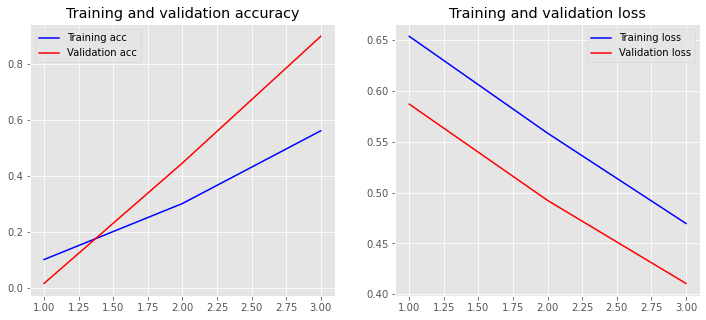

INFO:tensorflow:Assets written to: my_MOBATSim_classifier\assets


INFO:tensorflow:Assets written to: my_MOBATSim_classifier\assets


This particular CSV had a 74.8 percent probability 


<Figure size 432x288 with 0 Axes>

In [5]:
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")
history = model.fit(train_ds, epochs=3, validation_data=val_ds)
loss, accuracy = model.evaluate(test_ds)

print("--------------------------------Results----------------------------")
print("Accuracy", accuracy*100)


plot_history(history)
plt.show()
plt.savefig("output.png")


model.save('my_MOBATSim_classifier')
reloaded_model = tf.keras.models.load_model('my_MOBATSim_classifier')

sample = {
    'Time': 0.4001,
    'Speed': 2.2,
    'Rotation': 0,
    'Position': 370,
    'Translation': -369.544,
   
}


input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])



print(
    "This particular CSV had a %.1f percent probability "
     % (100 * prob)
)


In [6]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install graphviz